# Part 1: Generate Data

In [95]:
import numpy as np

dimension_count = 2
sd = 3
centers_count = 10
centers_mean = 0
centers_covariance = sd

centers1 = np.random.normal(loc=centers_mean, scale=centers_covariance, size=(centers_count, dimension_count))
centers2 = np.random.normal(loc=centers_mean, scale=centers_covariance, size=(centers_count, dimension_count))

In [103]:
centers_indices = np.arange(centers_count)
train_size = 100
test_size = 5000
sample_size = train_size + test_size
samples_sd = 0.5

selected_centers1 = np.random.choice(centers_indices, size=sample_size)
selected_centers1 = centers1[selected_centers1] # grab randomly selected centers
samples1 = np.random.normal(loc=selected_centers1, scale=samples_sd, size=(sample_size, dimension_count))
samples1 = np.append(samples1, np.zeros(sample_size).reshape(sample_size, 1), axis=1) # add column of 0's

selected_centers2 = np.random.choice(centers_indices, size=sample_size)
selected_centers2 = centers2[selected_centers2] # grab randomly selected centers
samples2 = np.random.normal(loc=selected_centers2, scale=samples_sd, size=(sample_size, dimension_count))
samples2 = np.append(samples2, np.ones(sample_size).reshape(sample_size, 1), axis=1) # add column of 1's

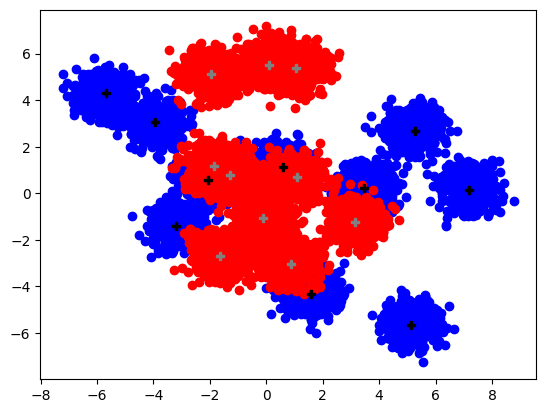

In [104]:
import matplotlib.pyplot as plt
plt.scatter(samples1[:, 0], samples1[:, 1], c="blue")
plt.scatter(samples2[:, 0], samples2[:, 1], c="red")

plt.scatter(centers1[:, 0], centers1[:, 1], c="black", marker="P")
plt.scatter(centers2[:, 0], centers2[:, 1], c="gray", marker="P")

# fig, ax = plt.subplots()
# ax.legend()

In [189]:
train_samples = np.concatenate([samples1[:train_size], samples2[:train_size]])
np.random.shuffle(train_samples)

test_samples = np.concatenate([samples1[train_size:], samples2[train_size:]])
np.random.shuffle(train_samples)

# Part 2: kNN

In [187]:
def kNN(train, test, k):
    predictions = []
    
    for i in range (test.shape[0]):
        distances = np.linalg.norm(train[:, :2] - test[i, :2], axis=1)
        distances = distances.reshape(distances.shape[0], 1)
        
        indices = np.arange(distances.shape[0])
        distances = np.append(distances, indices.reshape(distances.shape[0], 1), axis=1)
    
        distances = distances[distances[:, 0].argsort()]
        
        closest_points_indices = distances[:k][:, 1].astype(int)
        closest_points_class = train[closest_points_indices][:, 2]
    
        prediction = np.sum(closest_points_class) > (k / 2)
        predictions.append(prediction)
    
    return predictions

## Implementation

#### Distances Ties

From Numpy documentation for `argsort`:

When a is an array with fields defined, this argument specifies which fields to compare first, second, etc. A single field can be specified as a string, and not all fields need be specified, but unspecified fields will still be used, in the order in which they come up in the dtype, to break ties.

So precedent is given to training entry with lower index, which is random since we shuffled the dataset.

#### Voting Ties

If equal number of votes, then precedent is given to the `0` class

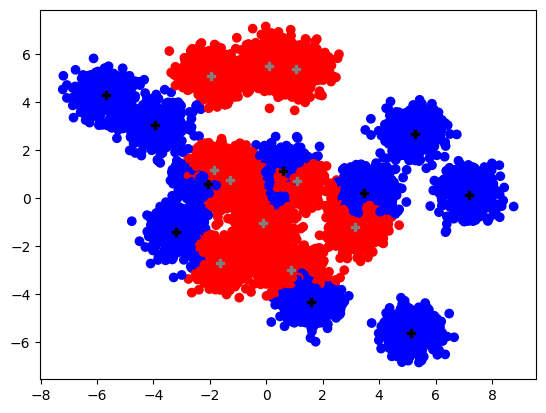

In [182]:
predictions = kNN(train_samples, test_samples, 1)

colors = ["red" if prediction else "blue" for prediction in predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], c=colors)

plt.scatter(centers1[:, 0], centers1[:, 1], c="black", marker="P")
plt.scatter(centers2[:, 0], centers2[:, 1], c="gray", marker="P")

In [183]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [190]:
print("1-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 1)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("3-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 3)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("5-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 5)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

1-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[4463  537]
 [ 441 4559]]
[[4463  537]
 [ 441 4559]]
3-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[4396  604]
 [ 336 4664]]
[[4396  604]
 [ 336 4664]]
5-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[4432  568]
 [ 376 4624]]
[[4432  568]
 [ 376 4624]]


# Part 3: cvKNN

In [224]:
import sys

n = train_samples.shape[0]
fold_count = 10
fold_size = n // fold_count

min_error = sys.maxsize
best_k = -1
for k in range(1, n - fold_size + 1):

    if k % 20 == 0:
        print("Currently testing: ", k)
        
    average_error = 0
    
    for i in range(fold_count):
        start = i * fold_size
        end = (i + 1) * fold_size
        
        holdout = train_samples[start:end]
        train_data = np.concatenate([train_samples[end:], train_samples[:start]])
    
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(train_data[:, :2], train_data[:, 2])
        predictions_sklearn = neigh.predict(holdout[:, :2])
    
        matrix = confusion_matrix(holdout[:, 2], predictions_sklearn)
        error = (matrix[0, 1] + matrix[1, 0]) / holdout.shape[0]
        average_error = ((average_error * i) + error) / (i + 1)
    
    if average_error <= min_error:
        min_error = average_error
        best_k = k

print(best_k)

Currently testing:  20
Currently testing:  40
Currently testing:  60
Currently testing:  80
Currently testing:  100
Currently testing:  120
Currently testing:  140
Currently testing:  160
Currently testing:  180
5
